In [58]:
import numpy as np

depth = np.array([1025, 1030, 1035, 1040, 1045, 1050])
GR = np.array([74, 55, 62, 64, 72, 66])
DT = np.array([600, 655, 625, 674, 572, 635])
RHOB = np.array([1800, 1585, 2025, 1745, 1785, 1865])
ILD= np.array([0.786, 0.856, 1.1, 0.981, 0.870, 0.953])
    
wellLog = np.stack((depth, GR, DT, RHOB, ILD), axis=1)

print(wellLog)


[[1.025e+03 7.400e+01 6.000e+02 1.800e+03 7.860e-01]
 [1.030e+03 5.500e+01 6.550e+02 1.585e+03 8.560e-01]
 [1.035e+03 6.200e+01 6.250e+02 2.025e+03 1.100e+00]
 [1.040e+03 6.400e+01 6.740e+02 1.745e+03 9.810e-01]
 [1.045e+03 7.200e+01 5.720e+02 1.785e+03 8.700e-01]
 [1.050e+03 6.600e+01 6.350e+02 1.865e+03 9.530e-01]]


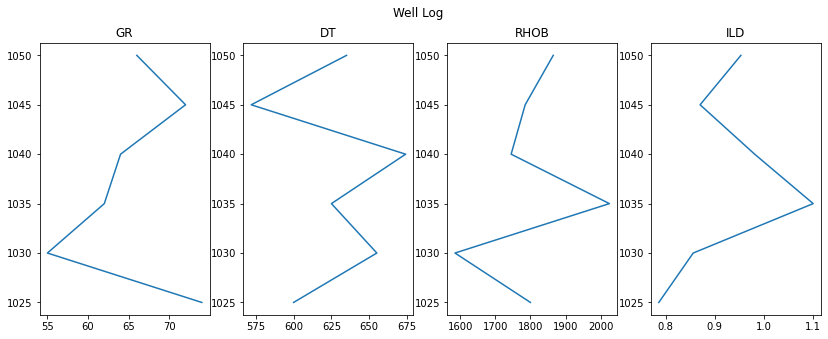

In [59]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(14, 5))
plt.subplot(141)
plt.plot(wellLog[:,1], wellLog[:,0])
plt.title('GR')
plt.subplot(142)
plt.plot(wellLog[:,2], wellLog[:,0])
plt.title('DT')
plt.subplot(143)
plt.plot(wellLog[:,3], wellLog[:,0])
plt.title('RHOB')
plt.subplot(144)
plt.plot(wellLog[:,4], wellLog[:,0])
plt.title('ILD')

plt.suptitle('Well Log')
plt.show()

In [60]:
import pandas as pd
df = pd.DataFrame(data=wellLog, columns=["DEPTH", "GR", "DT", "RHOB", "ILD"])
df.set_index("DEPTH", inplace=True)
df.head(7)

,GR,DT,RHOB,ILD
DEPTH,,,,
1025.0,74.0,600.0,1800.0,0.786
1030.0,55.0,655.0,1585.0,0.856
1035.0,62.0,625.0,2025.0,1.100
1040.0,64.0,674.0,1745.0,0.981
1045.0,72.0,572.0,1785.0,0.870
1050.0,66.0,635.0,1865.0,0.953


In [61]:
df.describe()

,GR,DT,RHOB,ILD
count,6.000000,6.000000,6.000000,6.000000
mean,65.500000,626.833333,1800.833333,0.924333
std,6.920983,36.918378,144.444338,0.111040
min,55.000000,572.000000,1585.000000,0.786000
25%,62.500000,606.250000,1755.000000,0.859500
50%,65.000000,630.000000,1792.500000,0.911500
75%,70.500000,650.000000,1848.750000,0.974000
max,74.000000,674.000000,2025.000000,1.100000


In [64]:
well=df
print (well["RHOB"])

DEPTH
1025.0    1800.0
1030.0    1585.0
1035.0    2025.0
1040.0    1745.0
1045.0    1785.0
1050.0    1865.0
Name: RHOB, dtype: float64


In [65]:
def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min):
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min)
    return round(vshale, 4)

def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

def rw_hingle(porosity, archieA, archieM, rt):
    rw= (porosity ** archieM) * (rt/archieA)
    return rw

def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

def sw_simandoux(phie, rt, rw, archieA, archieM, archieN, vshale, rshale):
    A = (1 - vshale) * archieA * rw / (phie ** archieM)
    B = A * vshale / (2 * rshale)
    C = A / rt
    
    sw = ((B **2 + C)**0.5 - B) **(2 / archieN)
    return sw

In [67]:
#calculate vshale
well['VSHALE']=shale_volume(well['GR'], well['GR'].quantile(q=0.99),
                             well['GR'].quantile(q=0.01))

#calculate Density from Porosity
well['PHI'] = density_porosity(well['RHOB'], 2.65, 1)

#Calculate PHIE
well['PHIECALC'] = well['PHI'] - (well['VSHALE'] * 0.3)

well['rw']=rw_hingle(well['PHI'],1, 2, well['ILD'])

In [68]:
print (well)

          GR     DT    RHOB    ILD  VSHALE        PHI    PHIECALC  \
DEPTH                                                               
1025.0  74.0  600.0  1800.0  0.786  1.0054 -1089.3030 -1089.60462   
1030.0  55.0  655.0  1585.0  0.856 -0.0189  -959.0000  -958.99433   
1035.0  62.0  625.0  2025.0  1.100  0.3585 -1225.6667 -1225.77425   
1040.0  64.0  674.0  1745.0  0.981  0.4663 -1055.9697 -1056.10959   
1045.0  72.0  572.0  1785.0  0.870  0.8976 -1080.2121 -1080.48138   
1050.0  66.0  635.0  1865.0  0.953  0.5741 -1128.6970 -1128.86923   

                  rw  
DEPTH                 
1025.0  9.326527e+05  
1030.0  7.872469e+05  
1035.0  1.652485e+06  
1040.0  1.093886e+06  
1045.0  1.015167e+06  
1050.0  1.214081e+06  


In [70]:
#Calculate Archie SW
well['SW'] = sw_archie(well['PHI'], well['ILD'], well['rw'], 1, 2, 2)

#Calculate Simandoux SW
well['SW_SIM'] = sw_simandoux(well['PHIECALC'], well['ILD'], well['rw'], 1, 2, 2, well['VSHALE'],2)

#Limit SW to 1
well['SW_LIM'] = well['SW'].mask(well['SW']>1, 1)
well['SW__SIM_LIM'] = well['SW_SIM'].mask(well['SW_SIM']>1, 1)

well.describe()

,GR,DT,RHOB,ILD,VSHALE,PHI,PHIECALC,rw,SW,SW_SIM,SW_LIM,SW__SIM_LIM
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000e+00,6.000000e+00,5.000000,6.000000e+00,5.000000
mean,65.500000,626.833333,1800.833333,0.924333,0.547167,-1089.808083,-1089.972233,1.115920e+06,1.000000e+00,0.664615,1.000000e+00,0.661907
std,6.920983,36.918378,144.444338,0.111040,0.373115,87.542036,87.575414,2.999290e+05,4.965068e-17,0.257211,4.965068e-17,0.252649
min,55.000000,572.000000,1585.000000,0.786000,-0.018900,-1225.666700,-1225.774250,7.872469e+05,1.000000e+00,0.300562,1.000000e+00,0.300562
25%,62.500000,606.250000,1755.000000,0.859500,0.385450,-1118.848500,-1119.053077,9.532812e+05,1.000000e+00,0.596868,1.000000e+00,0.596868
50%,65.000000,630.000000,1792.500000,0.911500,0.520200,-1084.757550,-1085.043000,1.054526e+06,1.000000e+00,0.671977,1.000000e+00,0.671977
75%,70.500000,650.000000,1848.750000,0.974000,0.816725,-1062.030300,-1062.202538,1.184032e+06,1.000000e+00,0.740126,1.000000e+00,0.740126
max,74.000000,674.000000,2025.000000,1.100000,1.005400,-959.000000,-958.994330,1.652485e+06,1.000000e+00,1.013541,1.000000e+00,1.000000


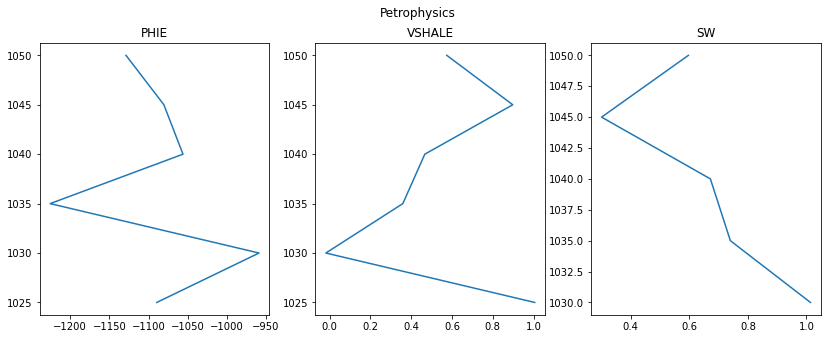

In [74]:
plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.plot(well["PHIECALC"], well.index)
plt.title('PHIE')
plt.subplot(132)
plt.plot(well["VSHALE"], well.index)
plt.title('VSHALE')
plt.subplot(133)
plt.plot(well["SW_SIM"], well.index)
plt.title('SW')

plt.suptitle('Petrophysics')
plt.show()